In this example, an equation for a contour of an axially symmetric
beam propagating in free space is checked.

Suppose there is an axially symmetric charged particles beam propagating
in free space.
Under certain set of approximations, trajectory of a particle on the edge 
of the beam can be described by the following expressions:

<!-- ![](http://mathurl.com/y7dt7wdq.png) -->
\begin{align}
  & r = r(0) e^{u^2}
  \\
  & z = 
  \left( \dfrac{m v^3}{q I} \right)^{1/2}
  r(0)
  \int_{0}^{u} e^{u^2} du
\end{align}


where $u$ is a parameter, $v$ is speed of particles along the $z$ axis,
$r(0)$ is initial radius and $I$ is full current of the beam.
Derivation of these relations can be found in supplementary notebook [link].

These equations define a contour of the beam $r(z)$. It is possible to perform 
a numerical simulation of a beam propagating in free space and 
plot particles coordinates on the X-Z or Y-Z plane. 
This will allow to compare the numerical profile
with the analytical expression. 

The beam will become $e = 2.71$ times wider than the initial at $u = 1$.
For this value of the parameter, the integral in the $z$ equation 
[approximately equals to](https://www.wolframalpha.com/input/?i=integrate%28+e^u^2,+u,+0,+1+%29) $1.46$. 
Since the speed in the $z$-direction is assumed constant, it is possible to estimate the time needed for  
particles to pass this distance as

<!-- ![](http://mathurl.com/yaaqzzhs.png) -->
\begin{align}
  t \approx 
  1.5 \left( \dfrac{m v}{q I} \right)^{1/2}
  r(0)
\end{align}

Let's substitute some numerical values (see the cell below). Suppose there is an electron beam ($q = 4.8 \cdot 10^{-10} ~ [\mbox{cgs}], ~ m = 9.1 \cdot 10^{-28} ~ [\mbox{g}]$) with full current $I = 0.1 ~ [\mbox{A}] = 2.998 \cdot 10^{8} ~ [\mbox{cgs}]$ and initial radius $r(0) = 0.5 ~ [\mbox{cm}]$. 
Energy of it's particles equals to 1 keV, so that speed is $v = 1.808 \cdot 10^{9} ~ [\mbox{cm/s}]$.
For this beam to get $2.71$ times wider (from $0.5 ~ [\mbox{cm}]$ to $1.36 ~ [\mbox{cm}]$), it takes $t = 2.63 \cdot 10^{-9} ~ [\mbox{s}]$ seconds.
This happens over a distance $z = 4.632 ~ [\mbox{cm}]$.

In [1]:
from math import *

m = 9.8e-28
q = 4.8e-10
print( "q = {:.3e} [cgs]".format( q ) )
print( "m = {:.3e} [g]".format( m ) )

r_0 = 0.5
print( "beam_radius = {:.3e} [cm]".format( r_0 ) )

ampere_to_cgs = 2997924536.8431
I = 0.1 * ampere_to_cgs
print( "I = {:.3e} [A] = {:.3e} [cgs]".format( I / ampere_to_cgs, I ) )

ev_to_cgs = 1.60218e-12
E = 1000 * ev_to_cgs
v = sqrt( 2 * E / m )
print( "E = {:.3e} [eV] = {:.3e} [erg]".format( E / ev_to_cgs, E ) )
print( "v = {:.3e} [cm/s]".format( v ) )

r0_e_times_wider = e * r_0
z_e_times_wider = 1.46 * sqrt( m * v**3 / q / I ) * r_0
t_e_times_wider = 1.5 * sqrt( m * v / q / I ) * r_0
print( "r0_e_times_wider = {:.3e} [cm]".format( r0_e_times_wider ) )
print( "t_e_times_wider = {:.3e} [s]".format( t_e_times_wider ) )
print( "z_e_times_wider = {:.3e} [cm]".format( z_e_times_wider ) )

q = 4.800e-10 [cgs]
m = 9.800e-28 [g]
beam_radius = 5.000e-01 [cm]
I = 1.000e-01 [A] = 2.998e+08 [cgs]
E = 1.000e+03 [eV] = 1.602e-09 [erg]
v = 1.808e+09 [cm/s]
r0_e_times_wider = 1.359e+00 [cm]
t_e_times_wider = 2.632e-09 [s]
z_e_times_wider = 4.632e+00 [cm]


These estimates can be used as a basis for config file parameters. 

Full simulation time is set to 3.0e-9 [s]. There are 100 time steps, with each 10th step written to file.

In [2]:
from ef.util.inject import configure_application
configure_application(solver="amgx", backend="cupy")

from ef.config.components import *

sim_time = 3.0e-9
n_of_steps = 100
dt = sim_time / n_of_steps
save_each_step = 10
dt_save = dt * save_each_step
time_grid = TimeGridConf(total=sim_time, step=dt, save_step=dt_save)
print(time_grid)

### TimeGridConf:
total = 3e-09
save_step = 3e-10
step = 3e-11


The simulation domain is defined as

In [3]:
mesh = SpatialMeshConf(size=(5, 5, 10), step=(.1, .1, .1))
print(mesh)

### SpatialMeshConf:
size = array([ 5,  5, 10])
step = array([0.1, 0.1, 0.1])


with z size approximately two times the estimated value, with 100 nodes in that direction. X and y sizes are 10 times the radius with 50 nodes in each direction.

The source is centered along the x and y axes and is close to origin along the z. For a time step dt = 3.00e-11 [s], to provide a current I = 0.1 [A] the source has to generate $n = I ~ dt ~/~ q = 1.87 \cdot 10^7$ particles each time step. This is not computationally feasible, so instead let's fix an amount of generated particles to 5000 at each step. The charge of macroparticles should be $Q = I ~ dt ~/~ n = 1.799 \cdot 10^{-6} ~ [\mbox{cgs}]$ To preserve charge-to-mass ratio, mass of the macroparticles should be set to $M = Q ~/~ q_e ~ m_e = 3.672 \cdot 10^{-24} ~ [\mbox{g}]$. To have the same initial velocity as electrons, mean momentum should be set to $p = M ~ v = 6.641 \cdot 10^{-15} ~ [\mbox{g * cm / s}]$.

In [4]:
num_of_real_particles = I * dt / q
print( "num_of_real_particles = {:.3e}".format( num_of_real_particles ) )

num_of_macro_particles = 5000
macro_q = I * dt / num_of_macro_particles
macro_m = macro_q / q * m
macro_mean_momentum = macro_m * v
print( "num_of_macro_particles = {:d}".format( num_of_macro_particles ) )
print( "macro_q = {:.3e} [cgs]".format( macro_q ) )
print( "macro_m = {:.3e} [g]".format( macro_m ) )
print( "macro_mean_momentum = {:.3e} [g * cm / s]".format( macro_mean_momentum ) )


source = ParticleSourceConf(
    name = "cathode_emitter",
    shape = Cylinder(start=(mesh.size[0]/2., mesh.size[1]/2., 0.52),
                     end=(mesh.size[0]/2., mesh.size[1]/2., 0.51),
                     radius=0.5),
    initial_particles = num_of_macro_particles,
    particles_to_generate_each_step = num_of_macro_particles,
    momentum = (0, 0, macro_mean_momentum),
    temperature = 0.0,
    charge = -macro_q,
    mass = macro_m
)

num_of_real_particles = 1.874e+07
num_of_macro_particles = 5000
macro_q = 1.799e-06 [cgs]
macro_m = 3.672e-24 [g]
macro_mean_momentum = 6.641e-15 [g * cm / s]


In [5]:
from ef.config.config import Config
from ef.config.visualizer import Visualizer3d
axially_symmetric_beam_conf = Config(time_grid, mesh, sources=[source])
vis = Visualizer3d()
axially_symmetric_beam_conf.visualize_all(vis)

<Figure size 640x480 with 1 Axes>

Potential is zero on each boundary of the domain (by default).

Other config parameters:

In [6]:
output_file = OutputFileConf(prefix = "contour_jup_", suffix = ".h5")
particle_interaction_model = ParticleInteractionModelConf(model = "PIC")

In [7]:
axially_symmetric_beam_conf = Config(time_grid, mesh, sources=[source],
                                     particle_interaction_model=particle_interaction_model,
                                     output_file=output_file)
print(axially_symmetric_beam_conf.export_to_string())

[TimeGrid]
total_time = 3e-09
time_save_step = 3e-10
time_step_size = 3e-11

[SpatialMesh]
grid_x_size = 5
grid_y_size = 5
grid_z_size = 10
grid_x_step = 0.1
grid_y_step = 0.1
grid_z_step = 0.1

[ParticleSourceCylinder.cathode_emitter]
cylinder_axis_start_x = 2.5
cylinder_axis_start_y = 2.5
cylinder_axis_start_z = 0.52
cylinder_axis_end_x = 2.5
cylinder_axis_end_y = 2.5
cylinder_axis_end_z = 0.51
cylinder_radius = 0.5
initial_number_of_particles = 5000
particles_to_generate_each_step = 5000
mean_momentum_x = 0.0
mean_momentum_y = 0.0
mean_momentum_z = 6.640708217582056e-15
temperature = 0.0
charge = -1.7987547221058602e-06
mass = 3.672457557632798e-24

[OutputFilename]
output_filename_prefix = contour_jup_
output_filename_suffix = .h5

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0

[ParticleInteractionModel]
particle_interaction_model = PIC




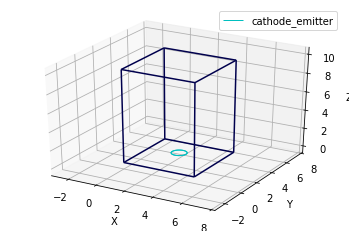

In [8]:
from ef.config.config import Config
from ef.config.visualizer import Visualizer3d
axially_symmetric_beam_conf.visualize_all(Visualizer3d())

In [9]:

from ef.runner import Runner
Runner(axially_symmetric_beam_conf.make(),
       output_writer=axially_symmetric_beam_conf.output_file.make()).start()

Writing initial fields to file
Writing to file contour_jup_fieldsWithoutParticles.h5
Writing step 0 to file
Writing to file contour_jup_0000000.h5
Time step from 9 to 10 of 100
Writing step 10 to file
Writing to file contour_jup_0000010.h5
Time step from 19 to 20 of 100
Writing step 20 to file
Writing to file contour_jup_0000020.h5
Time step from 29 to 30 of 100
Writing step 30 to file
Writing to file contour_jup_0000030.h5
Time step from 39 to 40 of 100
Writing step 40 to file
Writing to file contour_jup_0000040.h5
Time step from 49 to 50 of 100
Writing step 50 to file
Writing to file contour_jup_0000050.h5
Time step from 59 to 60 of 100
Writing step 60 to file
Writing to file contour_jup_0000060.h5
Time step from 69 to 70 of 100
Writing step 70 to file
Writing to file contour_jup_0000070.h5
Time step from 79 to 80 of 100
Writing step 80 to file
Writing to file contour_jup_0000080.h5
Time step from 89 to 90 of 100
Writing step 90 to file
Writing to file contour_jup_0000090.h5
Time ste

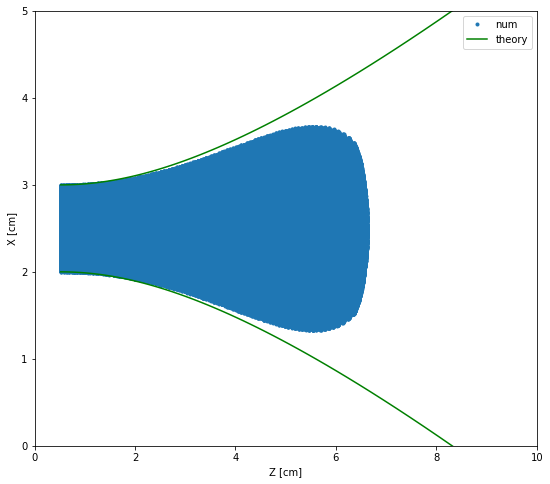

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

filename = 'contour_jup_0000100.h5'
h5file = h5py.File( filename, mode = "r" )

def get_source_current( h5file ):
    time_step = h5file["/TimeGrid"].attrs["time_step_size"]
    charge = h5file["/ParticleSources/cathode_emitter"].attrs["charge"]
    particles_per_step = h5file[
        "/ParticleSources/cathode_emitter"].attrs["particles_to_generate_each_step"]
    current = particles_per_step * charge / time_step
    return current
    
def get_source_geometry( h5file ):
    axis_start_x = \
        h5file["/ParticleSources/cathode_emitter"].attrs["cylinder_axis_start_x"]
    axis_start_z = \
        h5file["/ParticleSources/cathode_emitter"].attrs["cylinder_axis_start_z"]
    radius = h5file["/ParticleSources/cathode_emitter"].attrs["cylinder_radius"]
    return ( axis_start_x, axis_start_z, radius )

def get_source_particle_parameters( h5file ):
    mass = h5file["/ParticleSources/cathode_emitter"].attrs["mass"]
    charge = h5file["/ParticleSources/cathode_emitter"].attrs["charge"]
    momentum_z = h5file["/ParticleSources/cathode_emitter"].attrs["mean_momentum_z"]
    return ( mass, charge, momentum_z )

def beam_radius( u, r_0 ):
    return r_0 * np.exp( u ** 2 )

def beam_z( u, m, v, q, I, r_0 ):
    coeff = np.sqrt( m * v**3 / q / I ) * r_0
    subint = lambda t: np.exp( t * t )
    low_lim = 0
    up_lim = u
    integral_value = scipy.integrate.quad( subint, low_lim, up_lim )[0]
    return coeff * integral_value

beam_axis_x_pos, emitter_z_pos, r_0 = get_source_geometry( h5file )
I = get_source_current( h5file )
m, q, p = get_source_particle_parameters( h5file )
v = p / m

u_min = 0; u_max = 2; num_u_points = 100  # for u = 1, r = r(0) * 2.71812
u = np.linspace( u_min, u_max, num_u_points )
r_an = [ beam_radius( x, r_0 ) for x in u ]
r_an_upper = r_an + beam_axis_x_pos
r_an_lower = beam_axis_x_pos - r_an 
z_an = [ beam_z( x, m = m, v = v, q = q, I = I, r_0 = r_0 ) for x in u ]
z_an = z_an + emitter_z_pos

r_num = h5file["/ParticleSources/cathode_emitter/position_x"]
z_num = h5file["/ParticleSources/cathode_emitter/position_z"]

z_volume_size = h5file["/SpatialMesh"].attrs["z_volume_size"]
x_volume_size = h5file["/SpatialMesh"].attrs["x_volume_size"]
plt.xlabel( "Z [cm]" )
plt.ylabel( "X [cm]" )
plt.ylim( 0, x_volume_size )
plt.xlim( 0, z_volume_size )
plt.plot( z_num, r_num, '.', label = "num" )
plt.plot( z_an, r_an_upper, label = "theory", color = "g" )
plt.plot( z_an, r_an_lower, color = "g" )
plt.legend()
h5file.close()

#plt.savefig( "beam_contour.png" )
plt.show()